In [2]:
# Imports
import os

import torch
import torchvision
from torchvision.io import read_image
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

In [3]:
# Data

MANUAL_SEED = 42
BATCH_SIZE = 32
SHUFFLE = True

In [4]:
# Create dataset to load the images
class LandscapeDataset(Dataset):
    def __init__(self, transform=None):
        self.dataroot = './drive/landscape Images'
        self.images = os.listdir(f'{self.dataroot}/color')
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get image Paths
        img_path = self.images[idx]

        # Load the images
        color_img = read_image(f'{self.dataroot}/color/{img_path}') / 255
        gray_img = read_image(f'{self.dataroot}/gray/{img_path}') / 255

        if self.transform:
            color_img = self.transform(color_img)
            gray_img = self.transform(gray_img)

        return color_img, gray_img


In [5]:
transform = transforms.Compose([
    transforms.Resize((150, 150), antialias=False),
])
# Load the dataset
dataset = LandscapeDataset(transform=transform)

# Split the data into train and test data
train_set, test_set = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(MANUAL_SEED))

# Load the train and set data
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

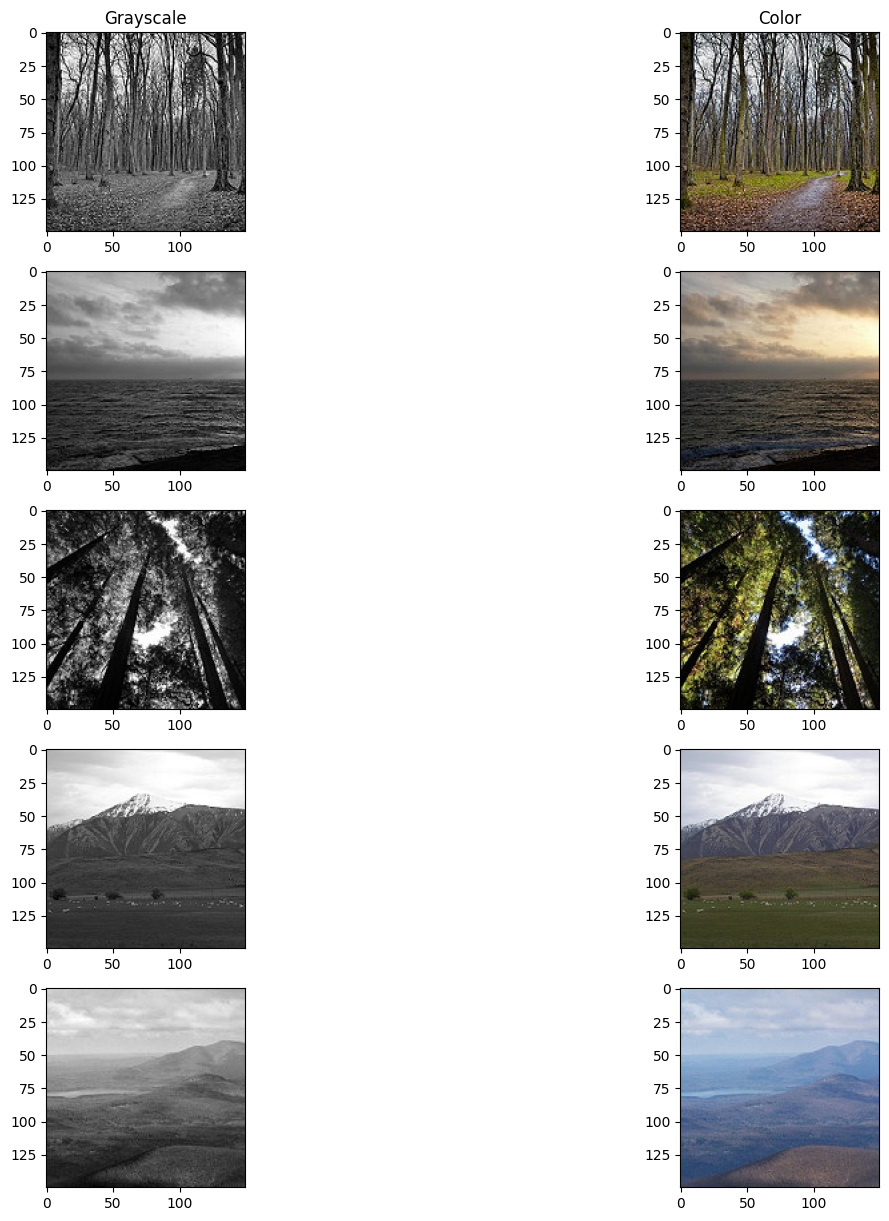

In [6]:
#Visualize some images
def show_images(color, gray):
    fig, axis = plt.subplots(5, 2, figsize=(15,15))
    axis[0,0].set_title('Grayscale')
    axis[0,1].set_title('Color')
    for i in range(5):
        axis[i,0].imshow(gray[i].permute(1,2,0), cmap='gray')
        #axis[i,0].axis('off')
        axis[i,1].imshow(color[i].permute(1,2,0))
        #axis[i,1].axis('off')
        
    plt.show()
    
color, gray = next(iter(trainloader))
show_images(color, gray)

In [7]:
# Training Variables

EPOCHS = 10
LEARNING_RATE = 0.001
MOMENTUM = 0.9
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
# Create the autoencoder model
class ColorAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Input shape: Bx1x150x150
        # Conv2d(in_channels, out_channels, kernel_size, stride, padding)

        self.down1 = nn.Conv2d(1, 64, 3, stride=2) # Bx64x74x74
        self.down2 = nn.Conv2d(64, 128, 3, stride=2, padding=1) # Bx128x37x37
        self.down3 = nn.Conv2d(128, 256, 3, stride=2, padding=1) # Bx256x19x29
        self.down4 = nn.Conv2d(256, 512, 3, stride=2, padding=1) # Bx512x10x10

        self.up1 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1)
        self.up2 = nn.ConvTranspose2d(512, 128, 3, stride=2, padding=1)
        self.up3 = nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=1)
        self.up4 = nn.ConvTranspose2d(128, 3, 3, stride=2, output_padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Down sample
        d1 = self.relu(self.down1(x))
        d2 = self.relu(self.down2(d1))
        d3 = self.relu(self.down3(d2))
        d4 = self.relu(self.down4(d3))
        # Upsample
        u1 = self.relu(self.up1(d4))
        u2 = self.relu(self.up2(torch.cat((u1,d3), dim=1)))
        u3 = self.relu(self.up3(torch.cat((u2, d2), dim=1)))
        u4 = self.sigmoid(self.up4(torch.cat((u3,d1), dim=1)))

        return u4

In [9]:
#Initiailize the model

model = ColorAutoEncoder().to(DEVICE)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
f"Total Number of trainable parameters of this model are: {total_params}"

'Total Number of trainable parameters of this model are: 3470659'

In [10]:
#Initialze the optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [11]:
#Define the training loop
for epoch in range(EPOCHS):
    running_loss = 0.0
    for idx, (color_img, gray_img) in tqdm(enumerate(trainloader), total=len(trainloader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)
        
        # Make model predictions
        predictions = model(gray_img)
        optimizer.zero_grad()
        
        #Calculate loss between colored image and predicted image
        loss = criterion(color_img, predictions)
        
        #Calculate gradients and back propagate
        loss.backward()
        optimizer.step()
        
        running_loss = loss.item()
        
    print(f'Epoch: {epoch + 1}, Loss: {running_loss:.6f}')

  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.007960


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.012871


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.008478


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.005911


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.004815


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.004386


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.004779


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.005123


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.005057


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.005394


In [12]:
# Test o ntesting data
total_loss = 0.0
with torch.no_grad():
    for idx, (color_img, gray_img) in tqdm(enumerate(testloader), total=len(testloader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)
        
        prediction = model(gray_img) 
        
        loss = criterion(prediction, color_img)
        total_loss += loss.item()
        
    print(f"Total testing loss is: {total_loss/len(testloader):.3f}") 

  0%|          | 0/45 [00:00<?, ?it/s]

Total testing loss is: 0.007


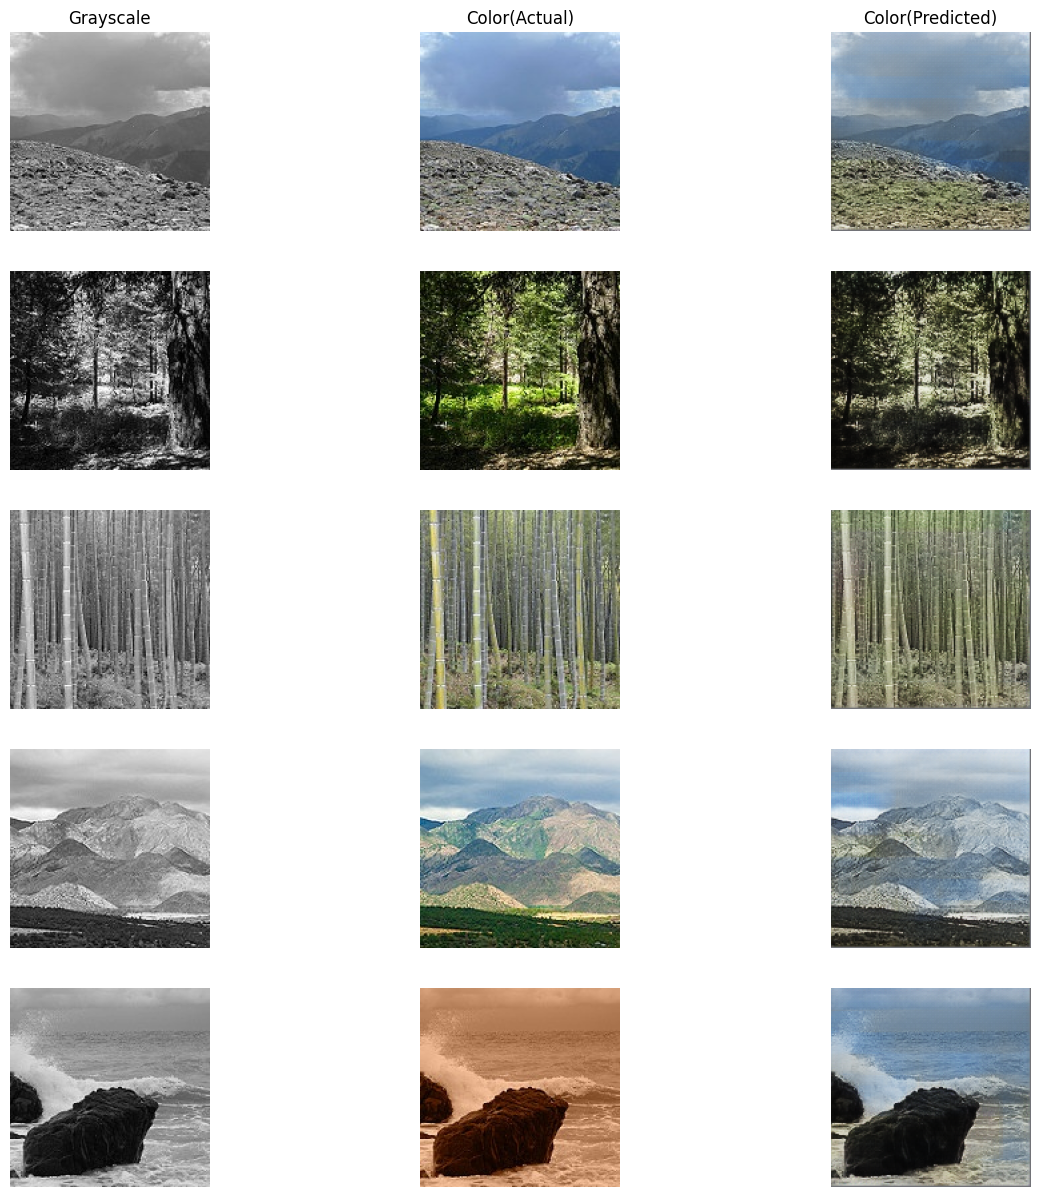

In [13]:
#Visualize some predcitions
def show_predictions(color, gray, pred):
    fig, axis = plt.subplots(5, 3, figsize=(15,15))
    axis[0,0].set_title('Grayscale')
    axis[0,1].set_title('Color(Actual)')
    axis[0,2].set_title('Color(Predicted)')
    for i in range(5):
        axis[i,0].axis('off')
        axis[i,0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axis[i,1].axis('off')
        axis[i,1].imshow(color[i].permute(1,2,0))
        axis[i,2].axis('off')
        axis[i,2].imshow(pred[i].permute(1,2,0))
    plt.show()
    
show_predictions(color_img.detach().cpu(), gray_img.detach().cpu(),prediction.detach().cpu())